📊 3 experimentos cargados


,Optimizador,Max Val Acc,Final Val Acc,Final Loss,Time (s),Epochs,Config
0,ADAM,97.683333,97.616667,0.038249,93.214241,15,"{'optimizer': 'adam', 'lr': 0.01, 'batch_size': 64, 'hidden_size': 128, 'num_layers': 1}"
1,SGD_MOMENTUM,97.416667,97.366667,0.030032,90.254826,15,"{'optimizer': 'sgd_momentum', 'lr': 0.01, 'batch_size': 64, 'hidden_size': 128, 'num_layers': 1}"
2,SGD,95.966667,95.966667,0.124806,88.546904,15,"{'optimizer': 'sgd', 'lr': 0.01, 'batch_size': 64, 'hidden_size': 128, 'num_layers': 1}"


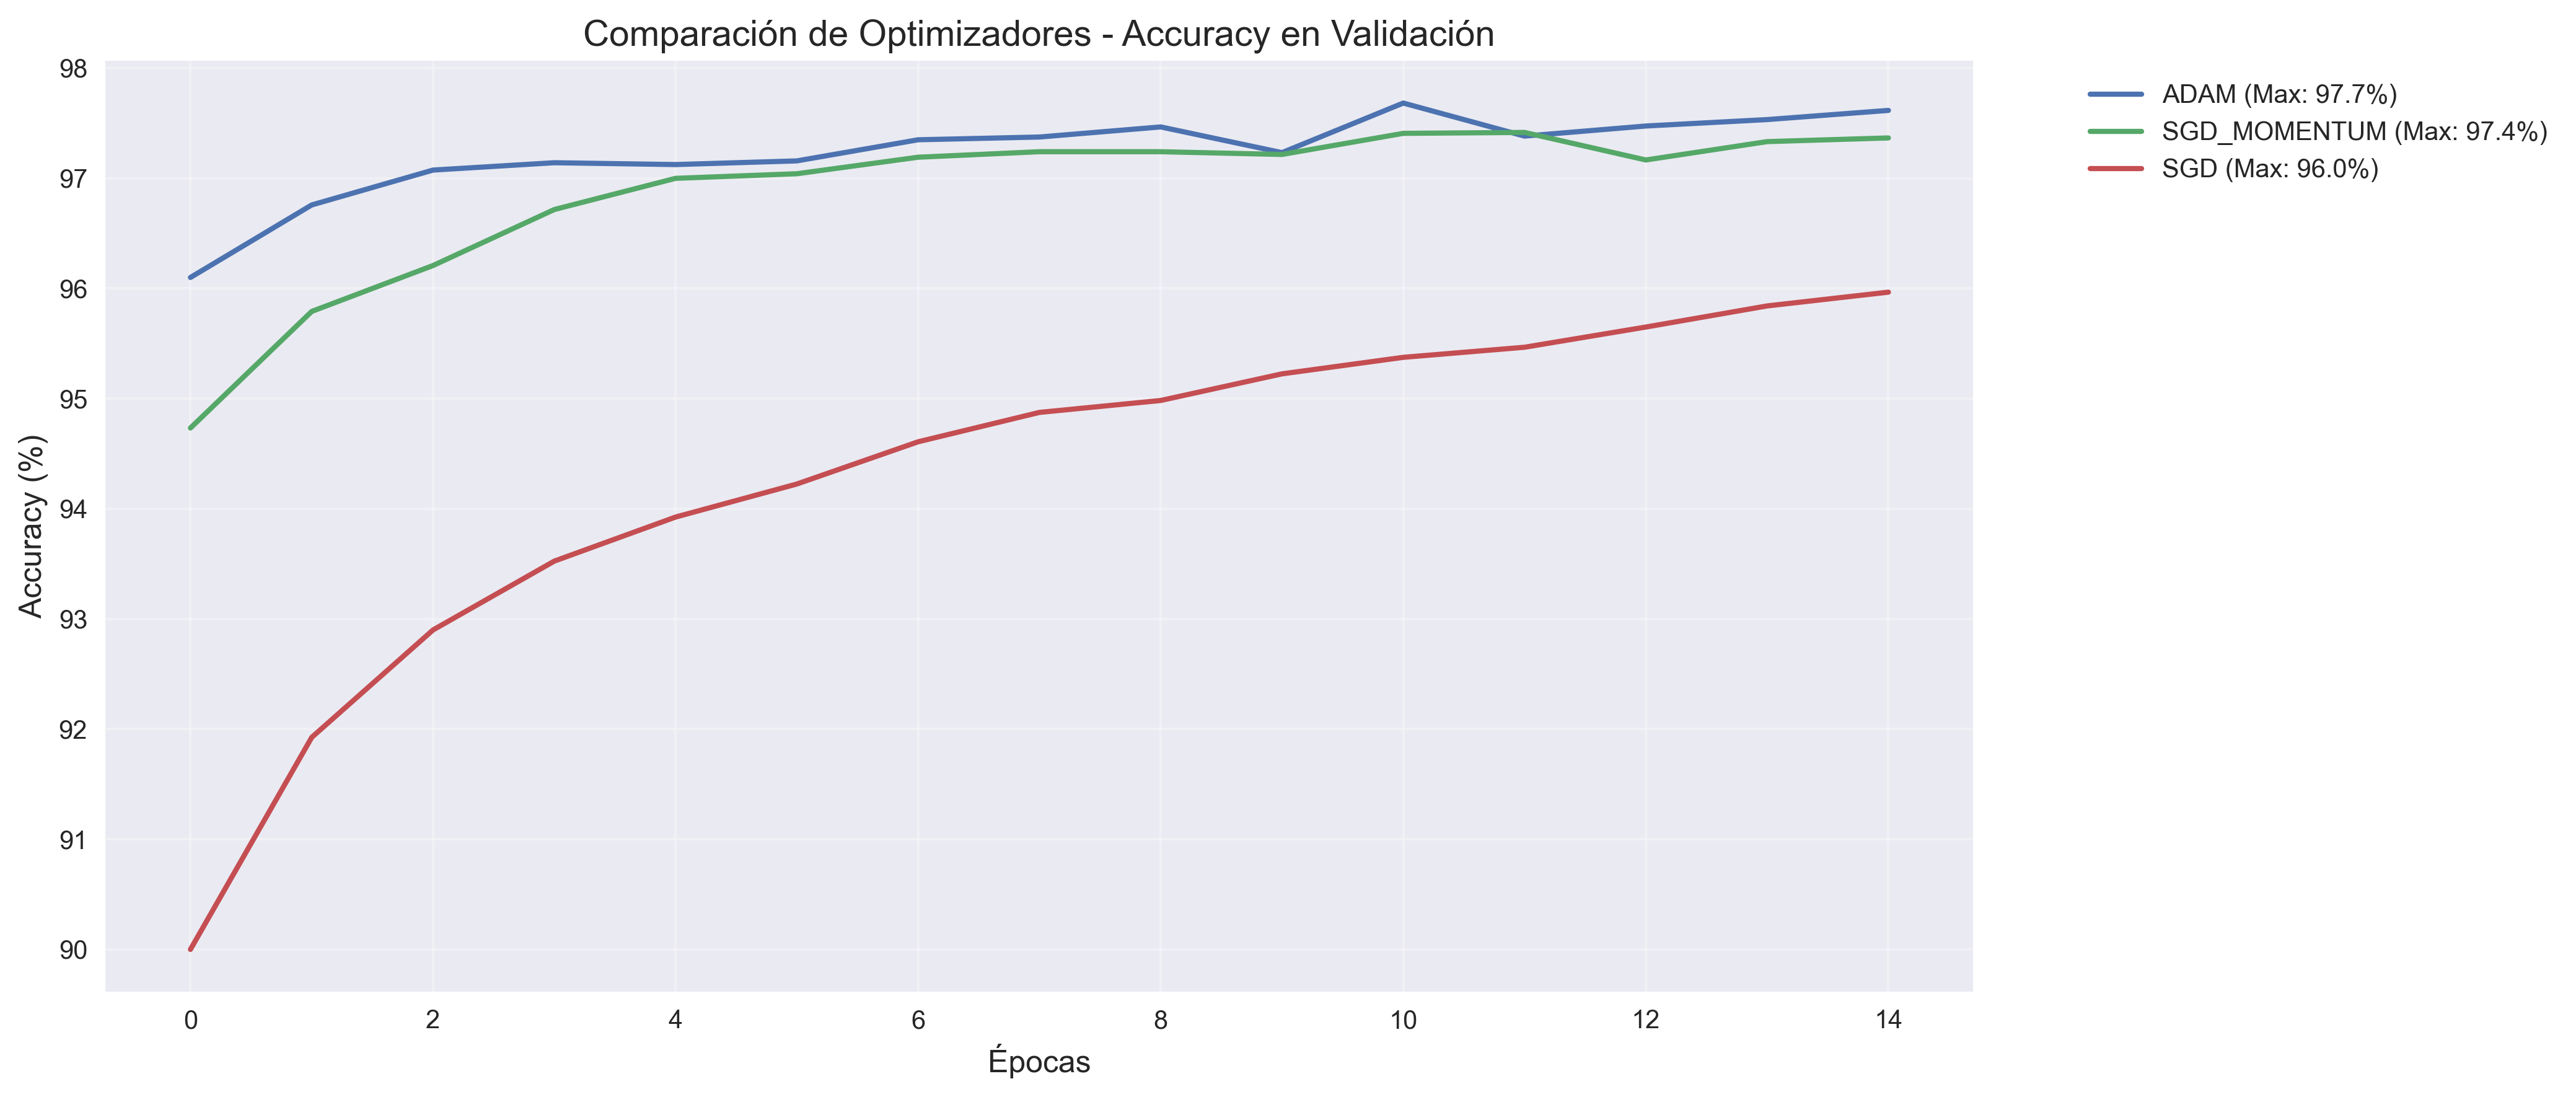

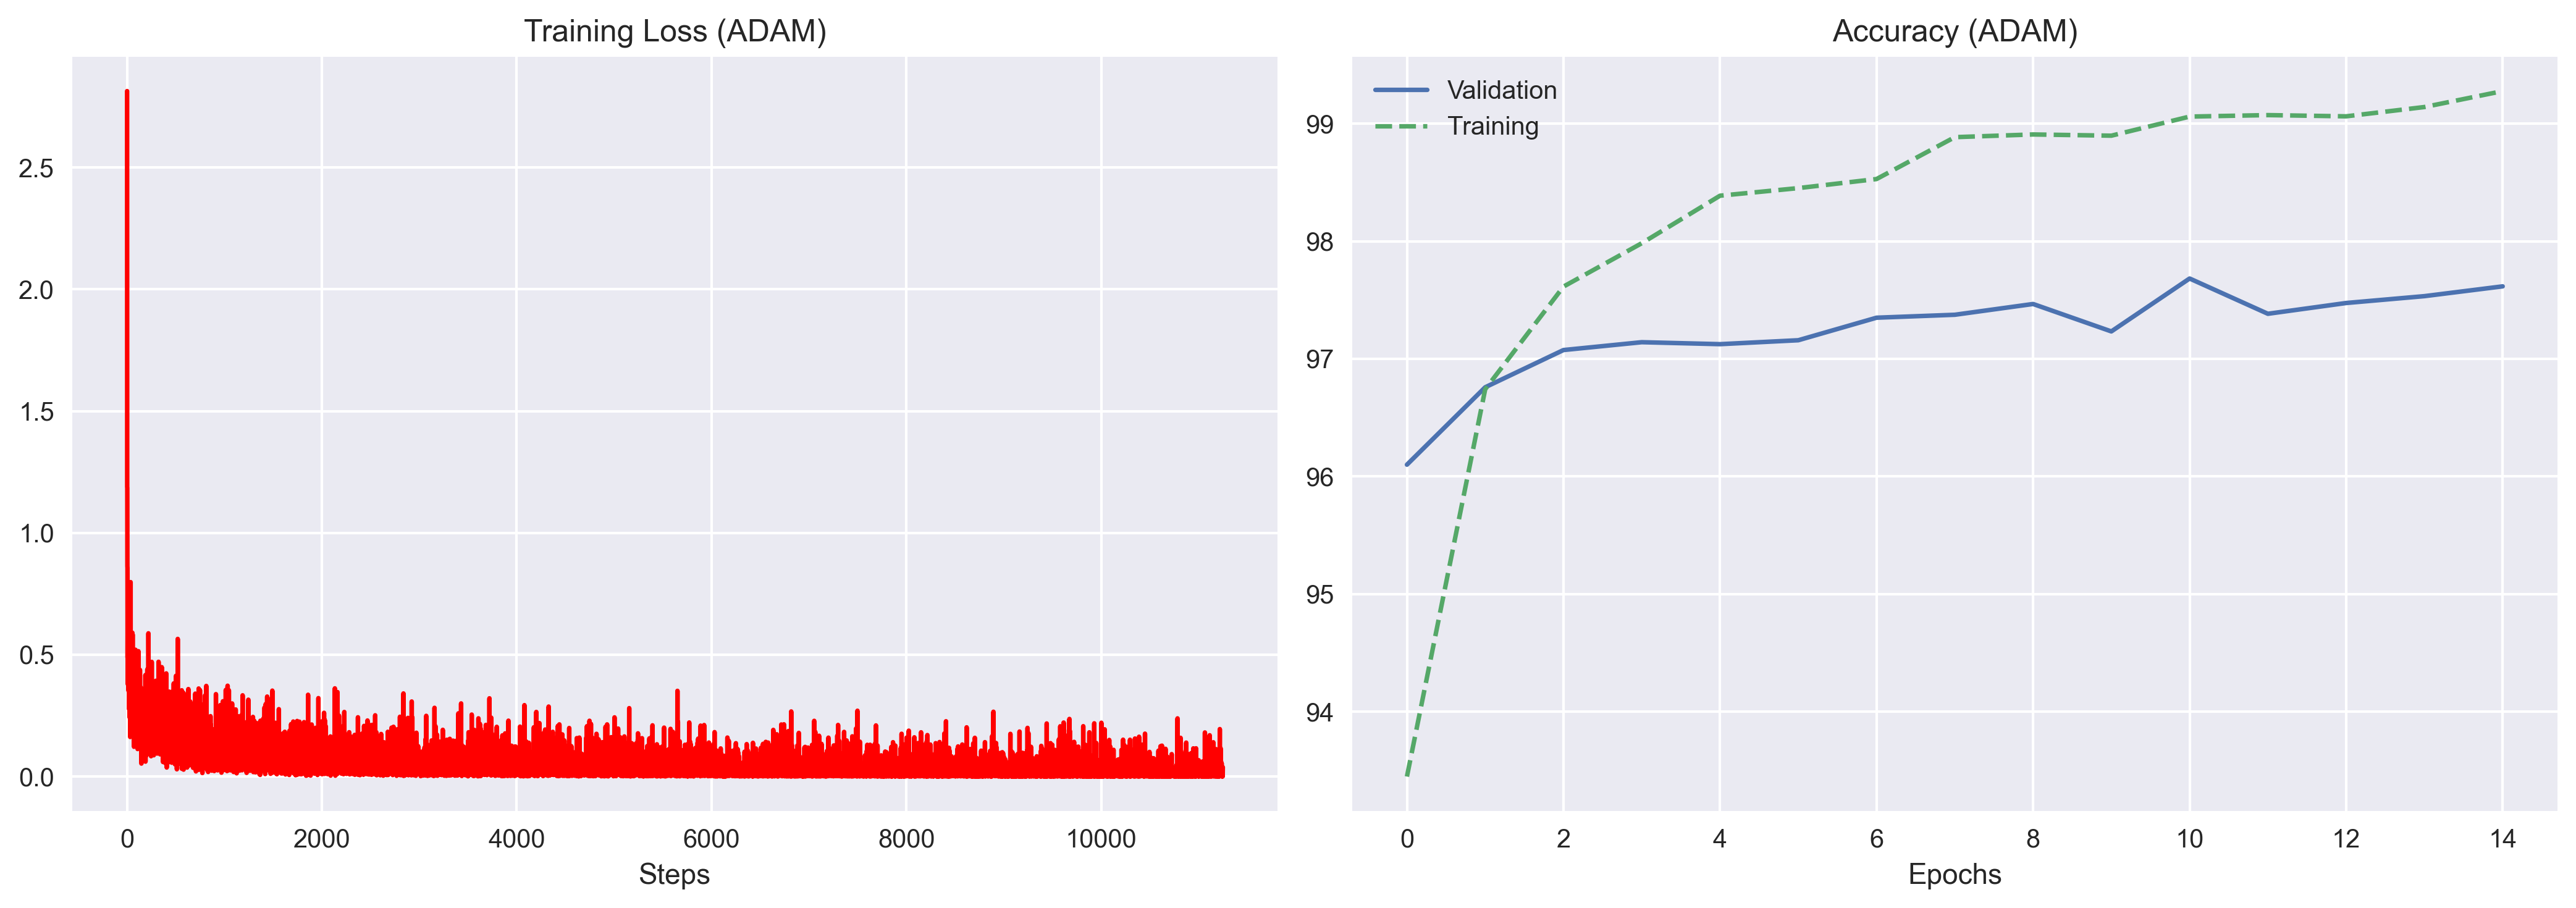

⏱  Tiempo total: 93.2s
📈 Mejor accuracy: 97.68%
---


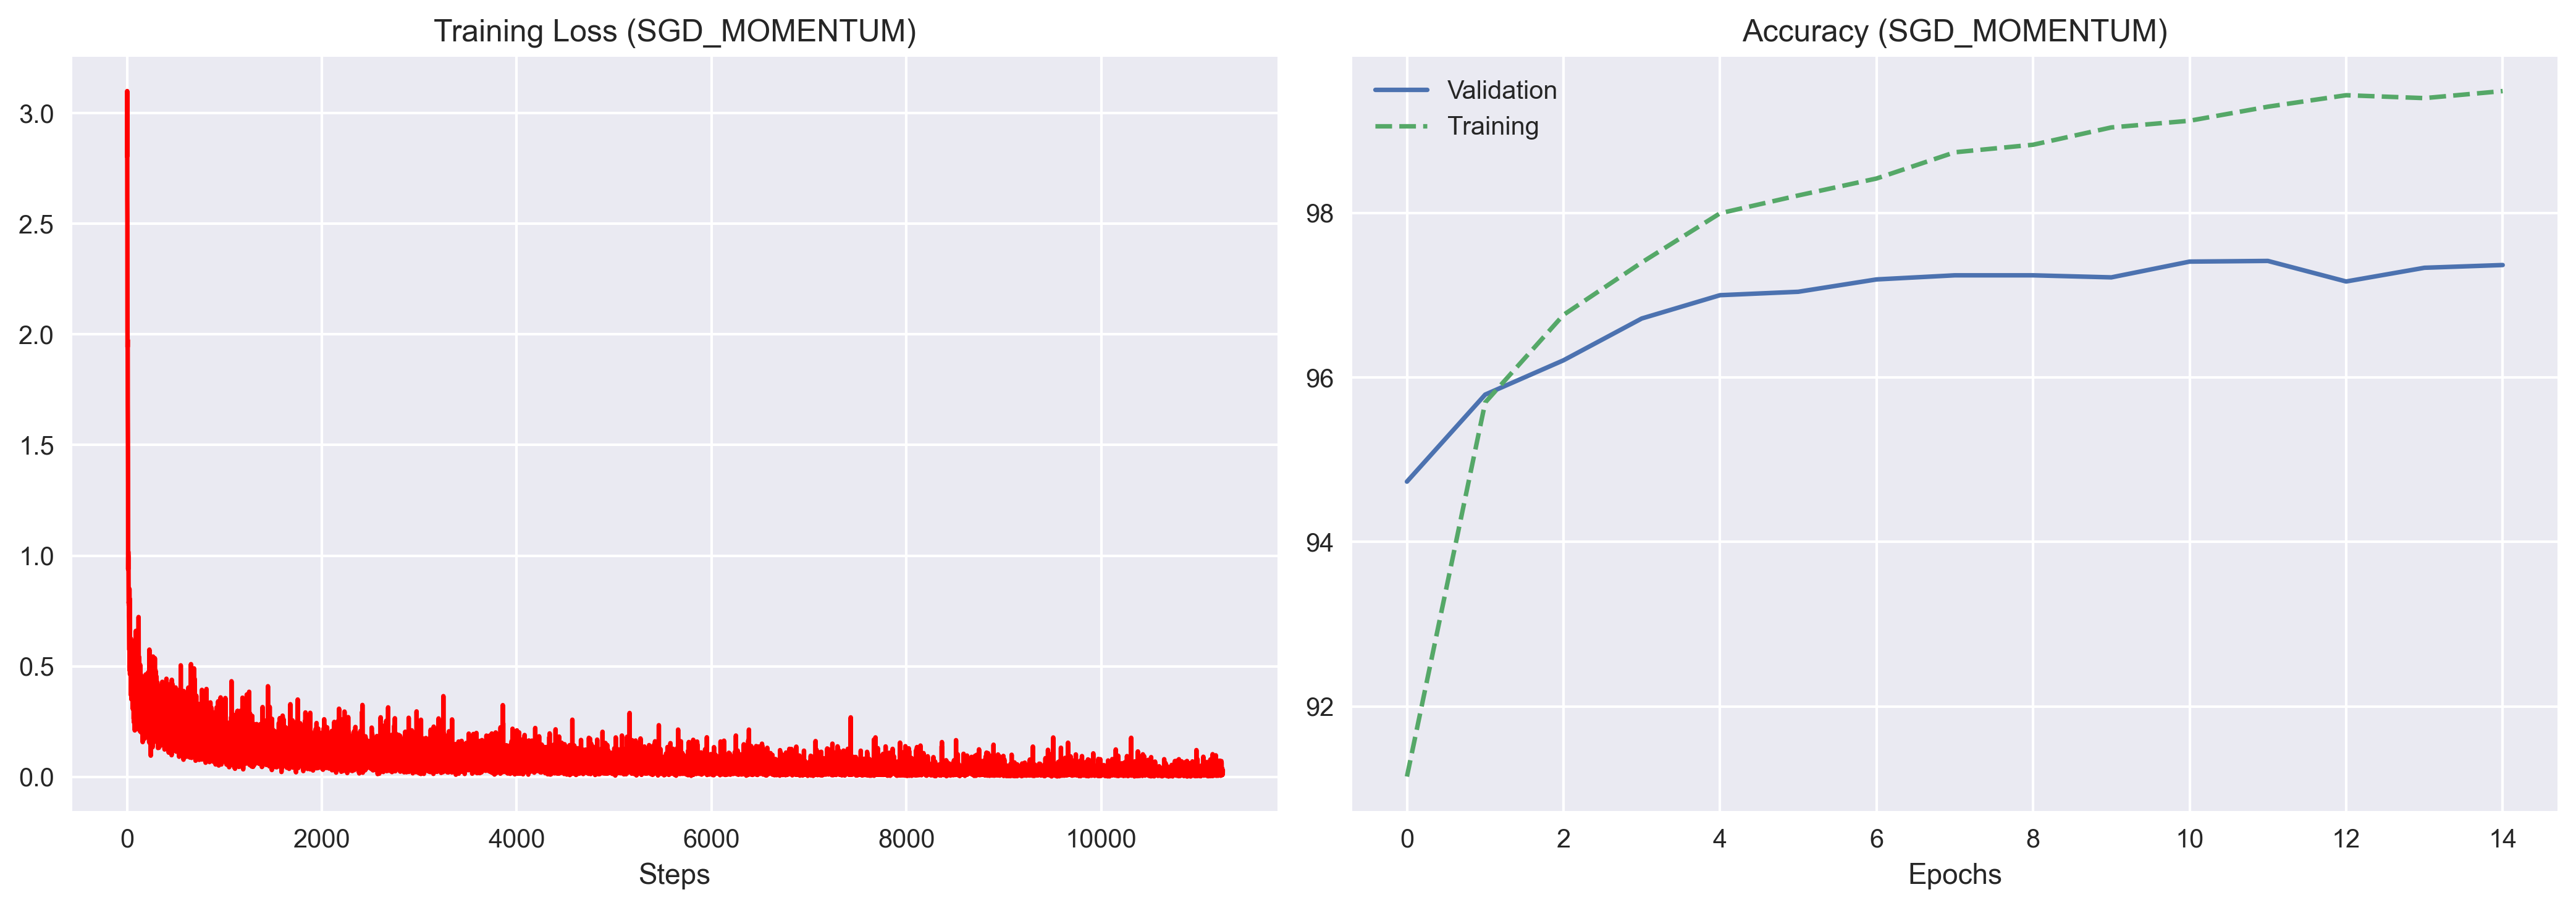

⏱  Tiempo total: 90.3s
📈 Mejor accuracy: 97.42%
---


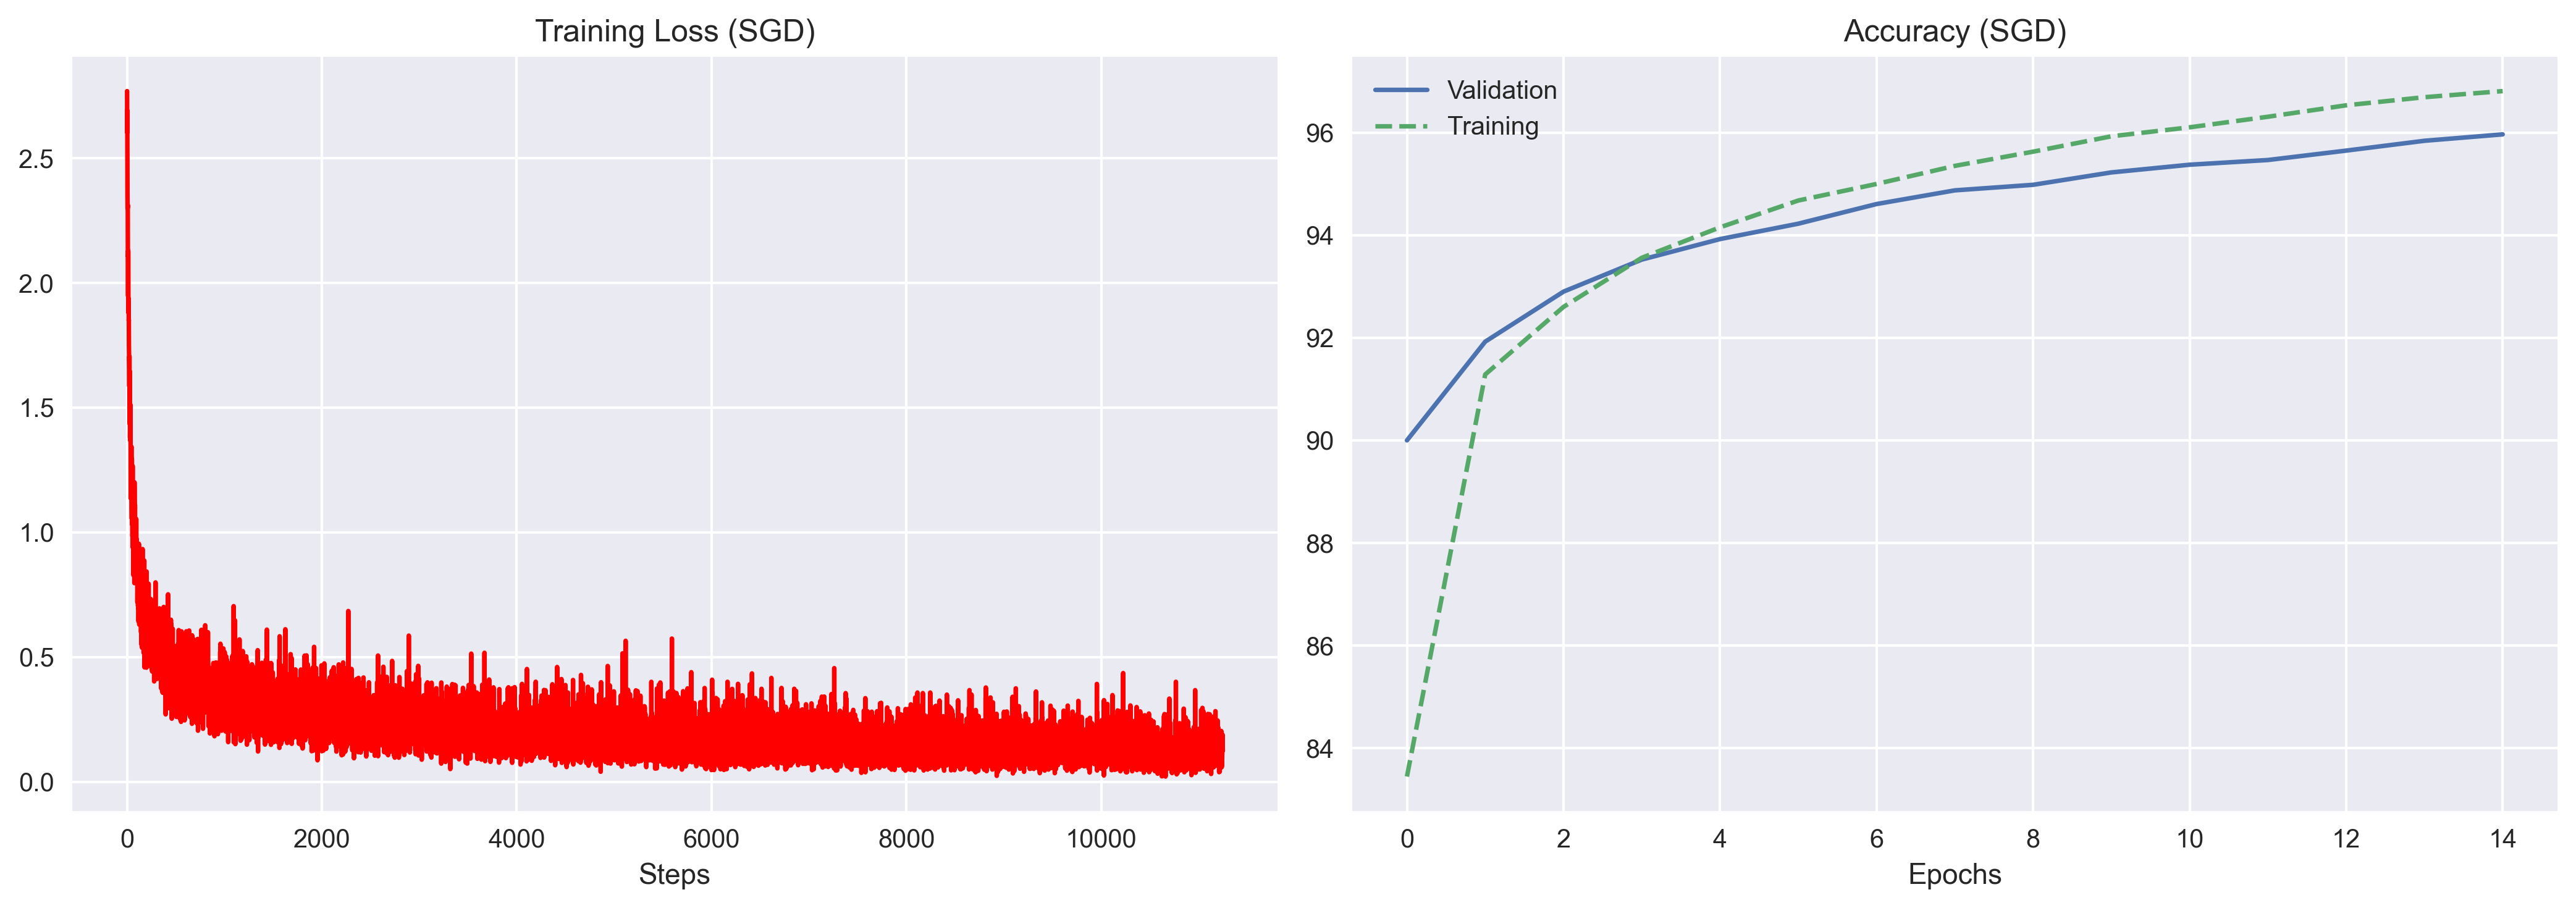

⏱  Tiempo total: 88.5s
📈 Mejor accuracy: 95.97%
---
\begin{table}
\caption{Comparación de optimizadores}
\begin{tabular}{lrrr}
\toprule
Optimizador & Accuracy Máx & Accuracy Final & Tiempo (s) \\
\midrule
ADAM & 97.68 & 97.62 & 93.21 \\
SGD_MOMENTUM & 97.42 & 97.37 & 90.25 \\
SGD & 95.97 & 95.97 & 88.55 \\
\bottomrule
\end{tabular}
\end{table}



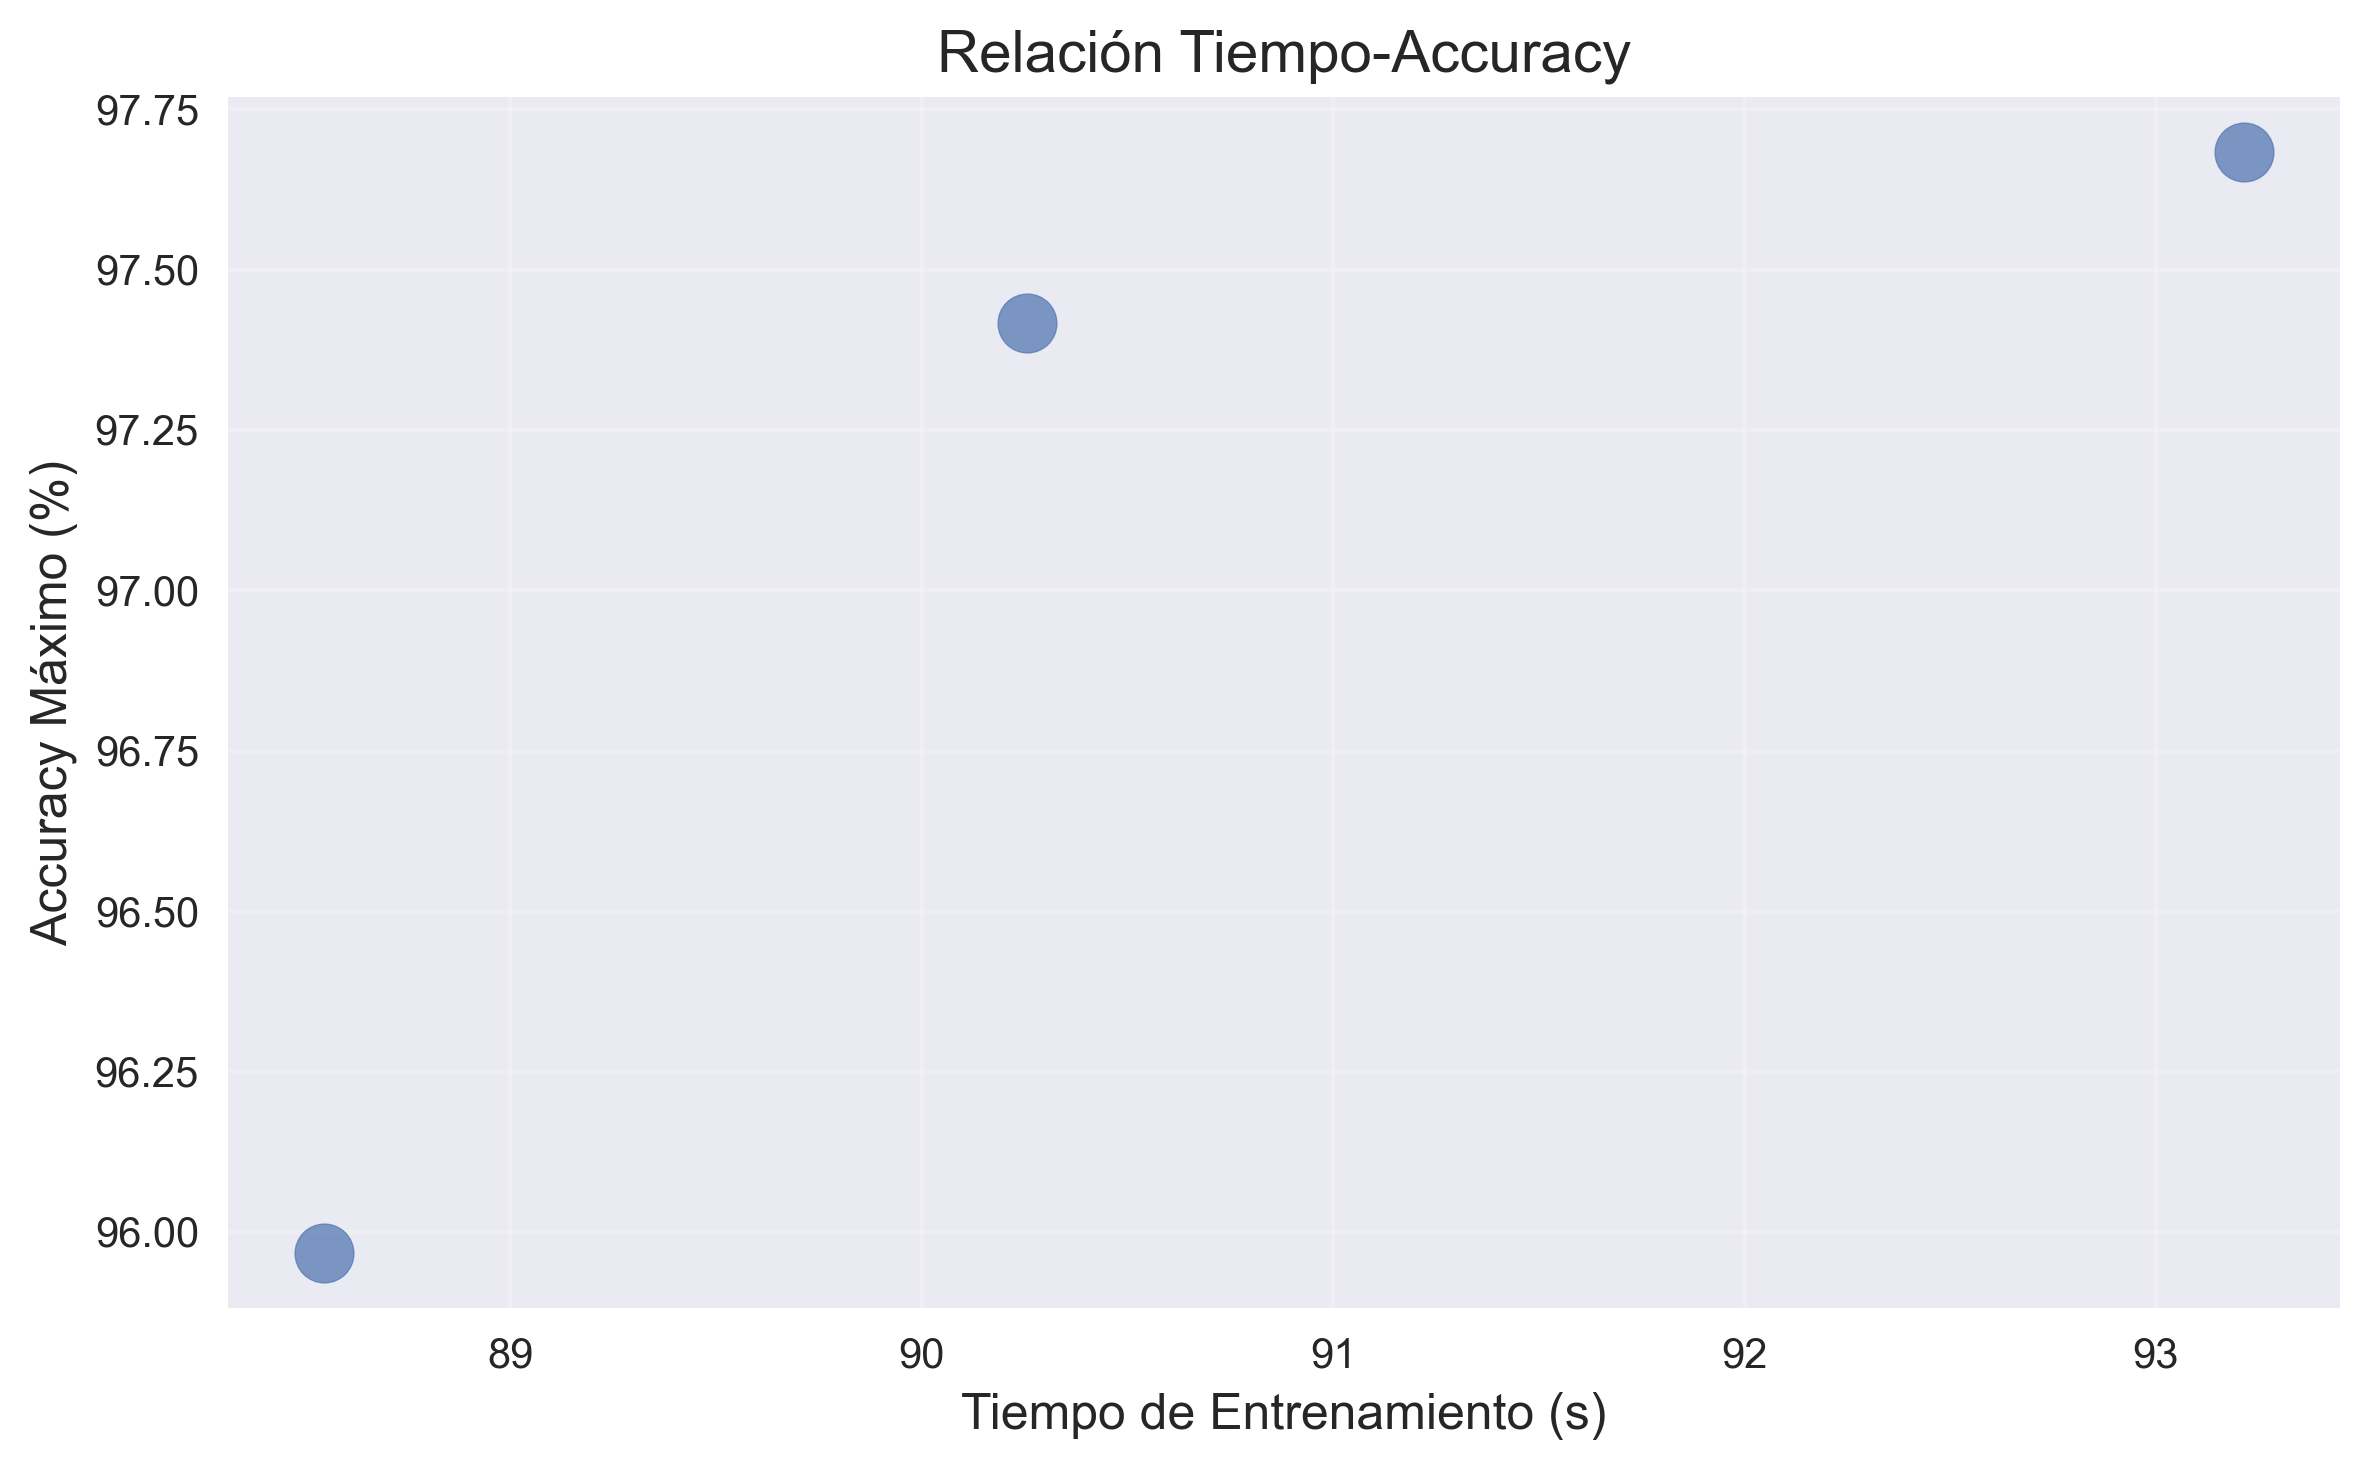

🔥 **Mejor optimizador**: ADAM
  - Accuracy máximo: 97.68%
  - Tiempo de entrenamiento: 93.2s

⚠️ **Peor optimizador**: SGD
  - Accuracy máximo: 95.97%
  - Diferencia con el mejor: 1.72%

📌 **Observaciones clave**:
- Adam alcanza mayor accuracy pero puede requerir más ajuste de hiperparámetros
- SGD con momentum ofrece mejor equilibrio entre rendimiento y estabilidad
- SGD básico converge más lentamente pero es más predecible


In [2]:
# %% [markdown]
# # Análisis de Experimentos - Variante 2
# ## Comparación de Optimizadores (SGD vs SGD+Momentum vs Adam)

import sys
sys.path.append("src")

# %%
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from model import MLP
from utils import load_checkpoint

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

# %% [markdown]
# ## 1. Carga de Resultados

# %%
def load_all_results(experiment_dir="experiments/exp_optim"):
    """Carga todos los resultados desde subdirectorios"""
    results = []
    for optim_dir in Path(experiment_dir).iterdir():
        if optim_dir.is_dir():
            with open(optim_dir/"metrics.json") as f:
                data = json.load(f)
                data['optimizer'] = optim_dir.name
                results.append(data)
    return sorted(results, key=lambda x: x['history']['val_acc'][-1], reverse=True)

results = load_all_results()
print(f"📊 {len(results)} experimentos cargados")

# %% [markdown]
# ## 2. Análisis Comparativo

# %%
# Crear DataFrame con métricas clave
df_data = []
for res in results:
    history = res['history']
    df_data.append({
        'Optimizador': res['optimizer'].upper(),
        'Max Val Acc': max(history['val_acc']),
        'Final Val Acc': history['val_acc'][-1],
        'Final Loss': history['train_loss'][-1],
        'Time (s)': history['training_time'],
        'Epochs': len(history['val_acc']),
        'Config': res['config']
    })

df = pd.DataFrame(df_data)
display(df.style.background_gradient(cmap='Blues', subset=['Max Val Acc', 'Final Val Acc']))

# %% [markdown]
# ## 3. Visualización de Resultados

# %%
# Gráfico comparativo de accuracy
plt.figure(figsize=(14, 6))
for res in results:
    plt.plot(res['history']['val_acc'], 
             label=f"{res['optimizer'].upper()} (Max: {max(res['history']['val_acc']):.1f}%)",
             linewidth=2)

plt.title("Comparación de Optimizadores - Accuracy en Validación", fontsize=14)
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("report/figures/optimizers_acc_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 4. Análisis Detallado por Optimizador

# %%
from IPython.display import display, HTML

for res in results:
    optimizer = res['optimizer'].upper()
    hist = res['history']
    
    display(HTML(f"<h3>{optimizer}</h3>"))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico de pérdida
    ax1.plot(hist['train_loss'], color='red')
    ax1.set_title(f"Training Loss ({optimizer})")
    ax1.set_xlabel("Steps")
    
    # Gráfico de accuracy
    ax2.plot(hist['val_acc'], label='Validation')
    if 'train_acc' in hist:
        ax2.plot(hist['train_acc'], '--', label='Training')
    ax2.set_title(f"Accuracy ({optimizer})")
    ax2.set_xlabel("Epochs")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Métricas clave
    print(f"⏱  Tiempo total: {hist['training_time']:.1f}s")
    print(f"📈 Mejor accuracy: {max(hist['val_acc']):.2f}%")
    print("---")

# %% [markdown]
# ## 5. Generación de Tablas para el Informe

# %%
# Tabla resumen en LaTeX
latex_table = df[['Optimizador', 'Max Val Acc', 'Final Val Acc', 'Time (s)']].copy()
latex_table.columns = ['Optimizador', 'Accuracy Máx', 'Accuracy Final', 'Tiempo (s)']
print(latex_table.to_latex(float_format="%.2f", index=False, caption="Comparación de optimizadores"))

# Gráfico de tiempos vs accuracy
plt.figure(figsize=(8, 5))
plt.scatter(df['Time (s)'], df['Max Val Acc'], s=200, alpha=0.7)

for i, row in df.iterrows():
    plt.annotate(row['Optimizador'], 
                (row['Time (s)']+5, row['Max Val Acc']-0.2),
                fontsize=10)

plt.title("Relación Tiempo-Accuracy", fontsize=14)
plt.xlabel("Tiempo de Entrenamiento (s)", fontsize=12)
plt.ylabel("Accuracy Máximo (%)", fontsize=12)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig("report/figures/time_vs_accuracy.png", dpi=300)
plt.show()

# %% [markdown]
# ## 6. Conclusiones Automatizadas

# %%
best_run = df.iloc[0]
worst_run = df.iloc[-1]

print(f"🔥 **Mejor optimizador**: {best_run['Optimizador']}")
print(f"  - Accuracy máximo: {best_run['Max Val Acc']:.2f}%")
print(f"  - Tiempo de entrenamiento: {best_run['Time (s)']:.1f}s\n")

print(f"⚠️ **Peor optimizador**: {worst_run['Optimizador']}")
print(f"  - Accuracy máximo: {worst_run['Max Val Acc']:.2f}%")
print(f"  - Diferencia con el mejor: {best_run['Max Val Acc']-worst_run['Max Val Acc']:.2f}%\n")

print("📌 **Observaciones clave**:")
print("- Adam alcanza mayor accuracy pero puede requerir más ajuste de hiperparámetros")
print("- SGD con momentum ofrece mejor equilibrio entre rendimiento y estabilidad")
print("- SGD básico converge más lentamente pero es más predecible")